# A/B Testing Randomized Experiment

This notebook is a simple demonstration of an A/B testing analysis using data from [Aman Chauhan on Kaggle](https://www.kaggle.com/datasets/whenamancodes/a-b-testing-randomized-experiment).

The data represent the number of views and clicks per user depending on whether the user was in the control or treatment group. 

In [1]:
# Setup environment with libraries and plotting settings
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from random import seed

plt.rcParams["figure.figsize"] = (8, 5)
plt.style.use("ggplot")
%matplotlib inline

In [2]:
# Import the data
file = "../data/ab_test_results_aggregated_views_clicks_4.csv"
dtypes = {"views": int, "clicks": int}
ab_data = pd.read_csv(file, dtype= dtypes) 

In [3]:
# No missing values, data are already very clean
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  110000 non-null  int64 
 1   group    110000 non-null  object
 2   views    110000 non-null  int32 
 3   clicks   110000 non-null  int32 
dtypes: int32(2), int64(1), object(1)
memory usage: 2.5+ MB


The data to do not include the click-through rate, so we'll add that, rounding to 2DP:

In [4]:
# Add the click through rate
ab_data["ctr"] = round(ab_data.clicks / ab_data.views, 2) * 100 # present as a percentage

ab_data.head()

,user_id,group,views,clicks,ctr
0,1,control,3,1,33.0
1,2,control,7,0,0.0
2,3,control,7,0,0.0
3,4,control,3,0,0.0
4,5,control,3,0,0.0


## Methods

We'll need to perform a hypothesis test to rigourously determine whether we should adopt the treatment applied.

In the case where the treatment ($t$) performs worse or the same as the control ($c$), we would fail to reject the null hypothesis ($H_0$), and take no action. Where the treatment performs better, we'd reject $H_0$, and adopt the treatment. We might measure this by comparing means, $\bar{x}$, for example.

$$
\begin{aligned}
H_0&: \bar{x}_{c} >= \bar{x}_{t}\\[2pt]
H_1&: \bar{x}_{c} < \bar{x}_{t}
\end{aligned}
$$

This would be done with a *t*-test, where the data meet its conditions:

1. Data are normally distributed - Central Limit Theorem may apply allowing a *t*-test even if not normally distributed
2. Homogeneity of variance between groups (homoskedasticity)
3. Observations are independent
4. Sampling is random

To determine the appropriate test, we need to investigate the data for these conditions. We cannot perform exploratory data analysis on the whole dataset without compromising the rigour of our hypothesis test, however, so we'll need to split it. 

We have over 100k rows, so this should be enough to accomodate an explore/test split.

In [5]:
print("No. of rows:", str(ab_data.shape[0]))

No. of rows: 110000


## Explore / Test Split

We'll spit our data into two equal portions.

In [6]:
# Set the random seed
seed(54)

# Take a 50% sample to calculate variance with
ab_eda_size = int(ab_data.shape[0] * 0.5)
ab_eda = ab_data.sample(ab_eda_size)

# Drop these rows from the original data to get the test sample
ab_testing = ab_data.drop(ab_eda.index)

Plotting this small subset suggests that the overwhelming majority of the data are distributed between 0% and 5% CTR, with a mostly uniform distribution above that.

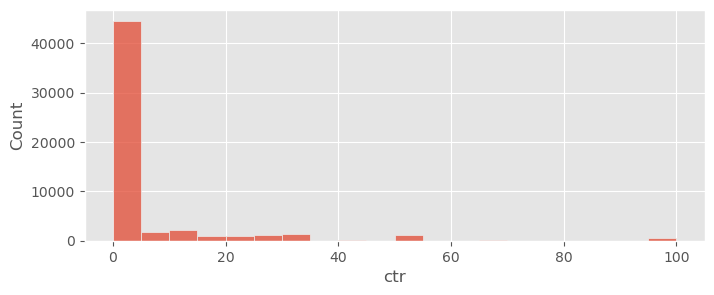

In [7]:
fig, ax = plt.subplots(figsize = (8, 3))
sns.histplot(ab_eda, x = "ctr", ax = ax, binwidth = 5);

Within the range 0% - 5%, the vast majority of values are 0%.

In [8]:
ab_eda[(ab_eda.ctr >= 0) & (ab_eda.ctr <= 5)].groupby("ctr").ctr.count()

ctr
0.0    44224
1.0        3
2.0       51
3.0      115
4.0      192
5.0      270
Name: ctr, dtype: int64

## Exploratory Analysis

Examing basic summary statistics shows the mean and maximum are higher for the treatment group ("test").

In [9]:
ab_eda.groupby("group")["ctr"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,27583.0,4.370482,12.829741,0.0,0.0,0.0,0.0,100.0
test,27417.0,5.331145,14.144065,0.0,0.0,0.0,0.0,100.0


Because "clicks" and "views" are discrete numerical (counts) variables, they are bounded at zero, which typically results in right-skewed distributions. This might follow through to the CTR distribution.

Exploring the two groups with a histogram confirms a very strong right skew; the majority of users clicked only once or no times.

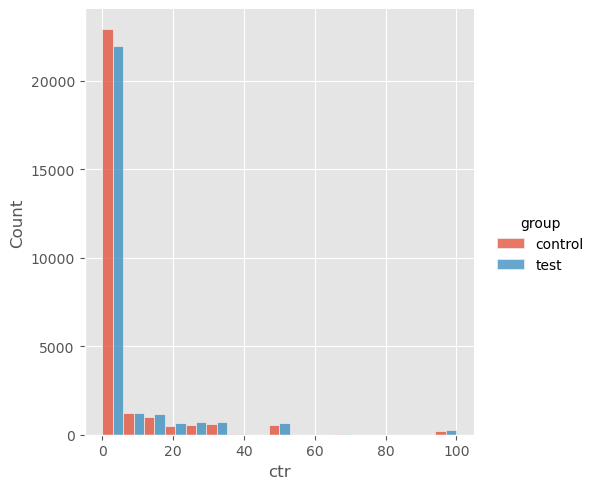

In [10]:
sns.displot(data = ab_eda, x="ctr", hue = "group", fill = True, multiple="dodge");

A KDE plot shows that the two groups are very similar. The treatment group has a slightly lower peak at 0, and its curve is just barely visible above that of the control group around 20%. There may therefore be a marginal effect to detect for the treatment, but we should not expect a significant result or a large effect size.

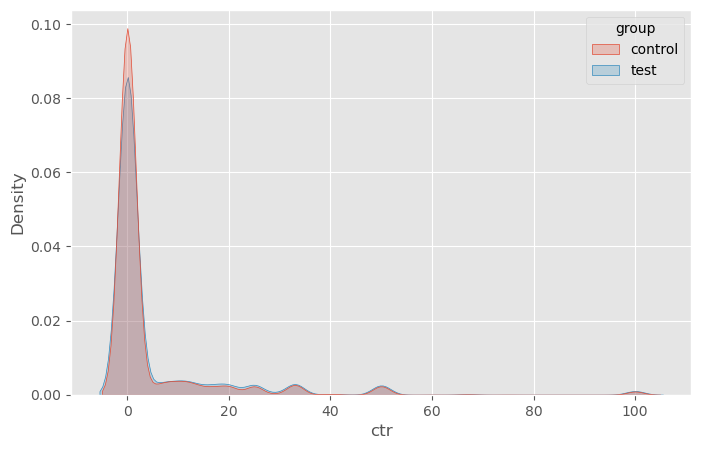

In [11]:
sns.kdeplot(data = ab_eda, x="ctr", hue = "group", fill = True, multiple="layer");

A boxplot highlights that clicking through at all marks a user as an outlier:

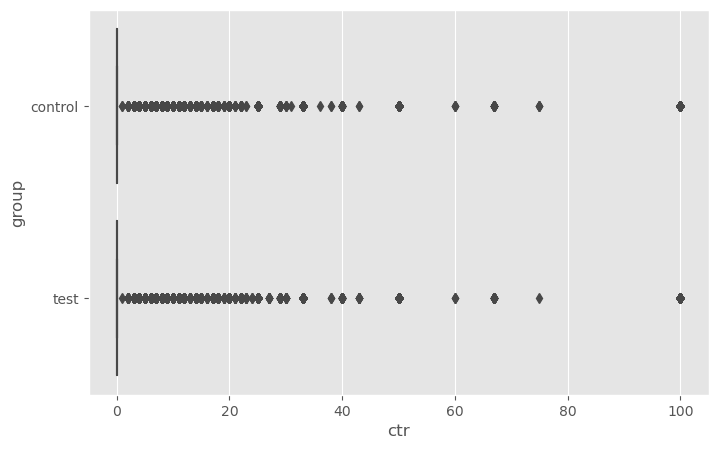

In [12]:
sns.boxplot(data = ab_eda, x="ctr", y = "group");

This raises whether the effect of the treatment is more detectable if the rows with CTR = 0 are ignored for both groups. Indeed this is the case; the treatment group has a higher median and a narrower inter quartile range.

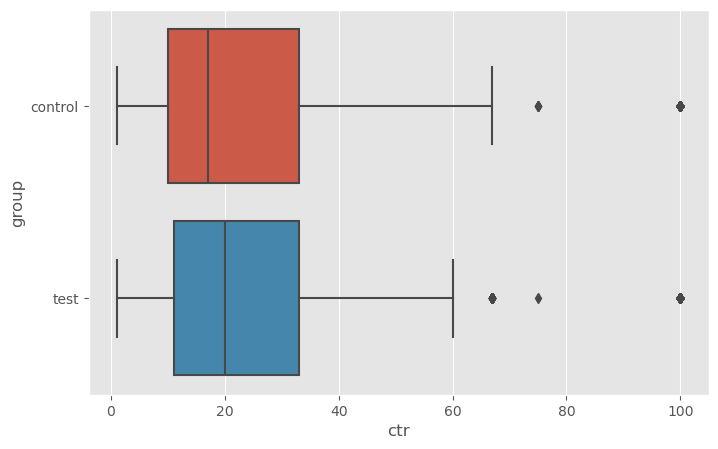

In [13]:
sns.boxplot(data = ab_eda[ab_eda.ctr != 0], x="ctr", y = "group");

## Choosing a test

With data this strongly skewed, it seems likely that Central Limit Theorem will not be enough to justify a *t*-test.

A Mann-Whitney *U* test will therefore be a better choice, so we'll optimise sample size for that. The *U* test compares distributions using their medians to determine whether they are different. Where $C$ and $T$ are randomly drawn single values from the control and treatment groups, respectively:

$$
\begin{aligned}
H_0&: P(C > T) = P(T > C)\\
H_1&: P(C > T) \ne P(T > C)\\
\end{aligned}
$$

## Mann-Whitney *U* Test & Effect Size

In [14]:
# Set some constants for our test parameters
ALPHA = 0.05
BETA = 0.8

In [15]:
ab_testing_control = ab_testing.query("group == 'control'").ctr
ab_testing_treatment = ab_testing.query("group == 'test'").ctr

In [16]:
mwu = stats.mannwhitneyu(ab_testing_control, ab_testing_treatment)
print(f"Reject null: {mwu.pvalue < ALPHA}, p = {mwu.pvalue}, n = {ab_testing.shape[0]}")

Reject null: True, p = 4.489110701063305e-12, n = 55000


We can calculate the rank biserial effect size ($r_{rb}$) from the test statistic: $r_{rb} = 1- {2U}/{n_1n_2}$

In [17]:
def r_rb(x, y, u):
    n_x = x.shape[0]
    n_y = y.shape[0]
    return 1-((2*u)/(n_x*n_y))

In [18]:
r_rb(ab_testing_control, ab_testing_treatment, mwu.statistic)

0.023625898524052835

A result of 0.03 confirms a weak effect for this treatment.

## Conclusion

A statistically significant result from $p < \alpha$ suggests that the treatment does create a difference in user behaviour that we can expect to occur in the whole user population.

However, the weak effect indicates that this is a marginal change and this is supported by the visualisations produced above for exploratory analysis.

It is probable that the hypothesis test was over-powered thanks to high sample size; we could improve upon this study with a post-hoc power analysis.

Adopting this treatment should not be recommended, especially if other treatments are being considered, or if the cost of implementation is high.